In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers as L


import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

In [2]:
directory = '../input/origalist/Cropped Images/Cropped Images'

In [3]:
img_datagen = ImageDataGenerator(rescale=1/255.,
                                zoom_range=0.2,
                                rotation_range=40,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                brightness_range=[0.2, 1.0],
                                vertical_flip=True,
                                horizontal_flip=True,
                                validation_split=0.2)

train_generator = img_datagen.flow_from_directory(directory,
                                                 target_size=(224, 224),
                                                 class_mode='binary',
                                                 subset='training',
                                                  batch_size=16,
                                                 shuffle=True)

valid_generator = img_datagen.flow_from_directory(directory,
                                                 target_size=(224, 224),
                                                 class_mode='binary',
                                                 subset='validation',
                                                  batch_size=1,
                                                 shuffle=True)

Found 1818 images belonging to 2 classes.
Found 454 images belonging to 2 classes.


In [4]:
model = keras.Sequential()

model.add(InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet'))
model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dropout(0.3))
model.add(L.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.SGD(1e-4, 0.9), loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

87916544/87910968 [==============================] - 1s 0us/step


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


In [6]:
train_generator.class_indices

{'Glaucoma': 0, 'Healthy': 1}

In [7]:
from sklearn.utils.class_weight import compute_class_weight
labels = train_generator.labels
weights = compute_class_weight('balanced', np.unique(labels), labels)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
class_weight = {0: weights[0],
               1: weights[1]}

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.7):
            print("\nReached 70% accuracy so cancelling training!")
            self.model.stop_training = True
        if (logs.get('val_auc') > 0.69):
            print("\nReached 70% AUC score so cancelling training!")
            self.model.stop_training = True

In [10]:
STEPS_PER_EPOCH = train_generator.n//train_generator.batch_size
VALIDATION_STEPS = valid_generator.n//valid_generator.batch_size
EPOCHS = 100


history = model.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                   validation_data=valid_generator, validation_steps=VALIDATION_STEPS, 
                    class_weight=class_weight, callbacks=[myCallback()], epochs=EPOCHS)

Epoch 1/100
113/113 [==============================] - 55s 486ms/step - loss: 0.7075 - accuracy: 0.4972 - auc: 0.5300 - val_loss: 0.7229 - val_accuracy: 0.4714 - val_auc: 0.4946
Epoch 2/100
113/113 [==============================] - 51s 448ms/step - loss: 0.6798 - accuracy: 0.5505 - auc: 0.5995 - val_loss: 0.6816 - val_accuracy: 0.5727 - val_auc: 0.5771
Epoch 3/100
113/113 [==============================] - 52s 457ms/step - loss: 0.6724 - accuracy: 0.5966 - auc: 0.6217 - val_loss: 0.6585 - val_accuracy: 0.6189 - val_auc: 0.6249
Epoch 4/100
113/113 [==============================] - 51s 448ms/step - loss: 0.6500 - accuracy: 0.6143 - auc: 0.6609 - val_loss: 0.6579 - val_accuracy: 0.6167 - val_auc: 0.6048
Epoch 5/100
113/113 [==============================] - 50s 443ms/step - loss: 0.6264 - accuracy: 0.6332 - auc: 0.7096 - val_loss: 0.6378 - val_accuracy: 0.6388 - val_auc: 0.6422
Epoch 6/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6156 - accuracy: 0.6521 - auc:

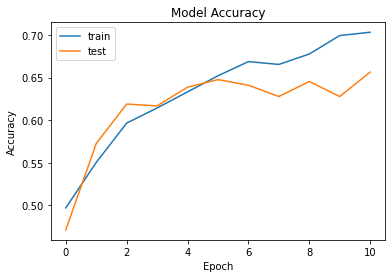

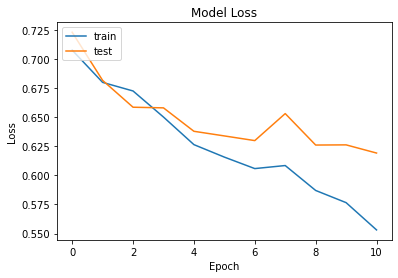

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model.save('final_model.h5')